# The KdV equation

In this notebook, we consider the one-dimensional forced Korteweg–de Vries (KdV) equation for waves on shallow water. It is given by
\begin{equation}
u_t + \eta u u_x + \gamma^2 u_{xxx} = g(x,t),
\end{equation}
where $\eta, \gamma \in \mathbb{R}$. If $g(x,t) = 0$, we have the standard unforced KdV equation.

For the standard KdV equation, the energy given by
$$
\begin{align*}
\mathcal{H}[u] &= \int_\mathbb{R} \left(-\frac{\eta}{6} u^3 + \frac{\gamma^2}{2}u_x^2 \right)\, dx
\end{align*}
$$

## Import libraries

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.random as random
import optimistix as optx
from functools import partial

jax.config.update("jax_enable_x64", True)
key = random.PRNGKey(0)

#from discretization import SpatialDiscretization, SpatioTemporalDiscretization, central_difference_1, central_difference_2

## Parameters

In [2]:
import numpy as np

In [3]:
η = 6.0
γ = 1.0
P = 20 # period (and end of the domain)
M = 100 # M+1 equally spaced points in the domain, but we exclude the last one due to periodicity
N = 500 # N+1 time points 

t0 = 0.0 # initial time
t_final = 5.0 # end time

dt = t_final / N # time step
dx = P / M # space step

x0 = 0.0 # initial position
x_final = P-dx # final position (excluding the last point due to periodicity)

x = jnp.linspace(x0, x_final, M) # domain
t = jnp.linspace(t0, t_final, N+1) # time domain

args = {"η" : η, "γ": γ, "dx" : dx}

## Generate initial conditions

In [4]:
def sech(x): return 1/jnp.cosh(x)

def initial_condition_kdv(x, key, η=6., P=20):
    """
    Generate the initial condition for the Korteweg-de Vries (KdV) equation.
    Parameters:
        x (float or array-like) : A single point or array in the spatial domain. 
        key (jax.random.PRNGKey): The random key for generating random numbers.
        η (float, optional): The coefficient for the KdV equation. Default is 6.
        P (float, optional): The period of the spatial domain. Default is 20.
    Returns:
        array-like: The initial condition for the KdV equation.
    """
    
    key_cs, key_ds = random.split(key, 2)
    c1, c2 = random.uniform(key_cs, minval=0.5, maxval=2, shape=(2,))
    d1, d2 = random.uniform(key_ds, minval=0, maxval=1, shape=(2,))
    
    u0 = (-6./-η)*2 * c1**2 * sech(c1 * ((x+P/2-P*d1) % P - P/2))**2
    u0 += (-6./-η)*2 * c2**2 * sech(c2 * ((x+P/2-P*d2) % P - P/2))**2
    return u0

In [5]:
#@jax.jit
def Dx(y, dx):
    y_next = jnp.roll(y, shift=1)
    y_prev = jnp.roll(y, shift=-1)
    
    return (y_next - y_prev) / (2 * dx)

#@jax.jit
def Dxx(y, dx):
    y_next = jnp.roll(y, shift=1)
    y_prev = jnp.roll(y, shift=-1)
    
    return (y_next - 2 * y + y_prev) / dx**2

In [6]:

def implicit_midpoint_step(f, tn, un, dt, args, rtol, atol):
    fn = f(tn, un, args)

    # The update should satisfy y1 = eq(y1), i.e. y1 is a fixed point of fn
    def eq(u, args):
        return un + dt * f(tn+0.5*dt, 0.5*(un+u), args)
    
    u_next_euler = un + dt * fn # Euler step as guess

    solver = optx.Newton(rtol, atol) # Chord is Newtons' method, but reuses the jacobian of the first guess
    u_next = optx.fixed_point(eq, solver, u_next_euler, args).value  # satisfies y1 == fn(y1)
    
    return u_next

@partial(jax.jit, static_argnums=(0,))
def implicit_midpoint(f, u0, dt, t, args, rtol, atol):
    def scan_body(carry, t):
        u, dt = carry
        u_next = implicit_midpoint_step(f, t, u, dt, args, rtol, atol)
        return (u_next, dt), u
    
    _, u_arr = jax.lax.scan(scan_body, (u0, dt), t)
    return u_arr

In [7]:
def f(t, u, args):
    η = args["η"]
    γ = args["γ"]
    dx = args["dx"]
    return -1.*Dx(0.5*η*u*u + γ**2 * Dxx(u, dx), dx)

In [8]:
u0 = initial_condition_kdv(x, random.PRNGKey(0))

atol, rtol = 1e-12, 1e-12

u_arr = implicit_midpoint(f, u0, dt, t, args, rtol, atol)

In [9]:
def H_energy(u, args):
    η, γ, dx = args["η"], args["γ"], args["dx"]
    integrand = (-η/6*u**3 + 0.5*γ**2*Dx(u, dx)**2)
    return dx*jnp.sum(integrand)

In [10]:
def H_mass(u, args):
    return dx * jnp.sum(u)

def H_momentum(u, args):
    return dx * jnp.sum(u**2)

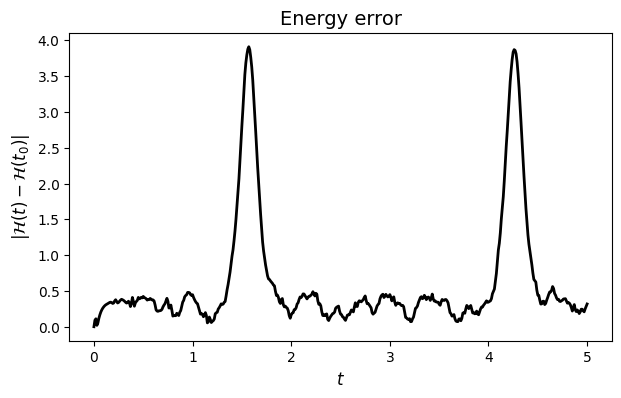

In [11]:
Hs = jax.vmap(H_energy, [0, None])(u_arr, args)

fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(t, jnp.abs(Hs-Hs[0]), 'k', linewidth=lw)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$|\mathcal{H}(t) - \mathcal{H}(t_0)|$', fontsize=12)
plt.title('Energy error', fontsize=14)
plt.show()

## Solve many KdVs at once!

We want to store the solutions in an array with shape (Samples,) where each element is a SpatioTemporalDiscretization

In [13]:
NUM_SAMPLES = 500

keys = random.split(random.key(0), NUM_SAMPLES)

a = jax.vmap(initial_condition_kdv, (None, 0))(x, keys)

data = jax.vmap(implicit_midpoint, (None, 0, None, None, None, None, None))(f, a, dt, t, args, rtol, atol)

In [14]:
train_val_test_split = [0.7, 0.15, 0.15]
train_split_idx = int(NUM_SAMPLES*train_val_test_split[0])
val_split_idx = int(NUM_SAMPLES*(train_val_test_split[0]+train_val_test_split[1]))

train, val, test = jnp.split(data, [train_split_idx, val_split_idx])

a_train = train[:,0]
u_train = train

a_val = val[:,0]
u_val = val

a_test = test[:,0]
u_test = test

jnp.savez("kdv", x=x, t=t, a_train=a_train, u_train=u_train, a_val=a_val, u_val=u_val, a_test=a_test, u_test=u_test)

jax.pure_callback failed
Traceback (most recent call last):
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\jax\_src\callback.py", line 86, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\jax\_src\callback.py", line 64, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\equinox\_errors.py", line 89, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: The maximum number of steps was reached in the nonlinear solver. The problem may not be solveable (e.g., a root-find on a function that has no roots), or you may need to increase `max_steps`.


--------------------
An error occurred during the runtime of your 

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sCpuCallback error: Traceback (most recent call last):
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\jax\_src\interpreters\mlir.py", line 2793, in _wrapped_callback
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\jax\_src\callback.py", line 228, in _callback
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\jax\_src\callback.py", line 89, in pure_callback_impl
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\jax\_src\callback.py", line 64, in __call__
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\equinox\_errors.py", line 89, in raises
_EquinoxRuntimeError: The maximum number of steps was reached in the nonlinear solver. The problem may not be solveable (e.g., a root-find on a function that has no roots), or you may need to increase `max_steps`.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------
